# Clustering Based Partitioning Heuristic

### We consume the edges with the heighest weight and keep performing this until we are left with two partitions

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
plt.rcParams["figure.figsize"] = (15,12)

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
        self.node_part = {}
    
    def addNode(self, node, affiliation='P1'):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation
        self.node_part[node] = [node]
    
    def delNode(self, nodes):
        for i in nodes:
            self.nodes.remove(i)

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def consume_edge(self, edge):
        self.node_part[edge[0]] += self.node_part[edge[1]]
        self.nodes.remove(edge[1])
        weight_dicts = {}
        delete_indices  = []
        edges = self.adj_list

        for i in range(len(self.adj_list)):
            if(edges[i][0] == edge[1] and edges[i][1] != edge[0]):
                if(edges[i][1] in weight_dicts.keys()):
                    weight_dicts[edges[i][1]] += edges[i][2]
                else:
                    weight_dicts[edges[i][1]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] != edge[0]):
                if(edges[i][0] in weight_dicts.keys()):
                    weight_dicts[edges[i][0]] += edges[i][2]
                else:
                    weight_dicts[edges[i][0]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] == edge[0]):
                delete_indices.append(i)
            else:
                pass
        
        delete_indices.sort(reverse=True)
        for x in delete_indices:
            del self.adj_list[x]

        for p in weight_dicts.keys():
            self.addEdge(edge[0], p, weight_dicts[p])
        
        self.num_nodes = len(self.nodes)
    
    def get_heaviest_edge(self):
        sorted_edges = sorted(self.adj_list, key= lambda x: x[2], reverse=True)
        return sorted_edges[0] 
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost
        
class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()
        self.colors = {}
    
    def reset(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p = list(set(self.graph.node_affiliation.values()))
        
        partitions = []
    
        for k in p:
            partitions.append([i for i in nodes if self.graph.node_affiliation[i] == k])
            if k not in self.colors.keys():
                self.colors[k] = '#%06X' % random.randint(0, 0xFFFFFF)
            
        
        node_colors = [self.colors[self.graph.node_affiliation[n]] for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = node_colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        
        legend_handles = []
        for i in p:
            legend_handles.append(mpatches.Patch(color=self.colors[i], label=i))
        plt.legend(handles=legend_handles)
        plt.show()

In [2]:
def clustering_based_partitioning(graph, m, visualize = True):
    global v
    ''' graph is the network of class Graph() which we wish to partition
        m is the number of final partitions to be left after partitioning'''

    if(graph.num_nodes <= m):
        print("No need of partitioning as the number of partitions is <= m")
    else:
        iterations = 1
        while(graph.num_nodes > m):
            if visualize:
                v.reset()
                v.addEdges(graph)
                v.visualize(f"Before Iteration {iterations}")
            e = graph.get_heaviest_edge()
            graph.consume_edge(e)
            iterations += 1
    if visualize:
        v.reset()
        v.addEdges(graph)
        v.visualize(f"Final Partitioned Network")

In [3]:
v = GraphVisualizer()

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import random


def generate_benchmark(n=26, seed=20160):
    #n is number of nodes
    random.seed(seed)
    G = nx.erdos_renyi_graph(n, 0.5, seed=seed)

    for edge in G.edges():
        wt = random.randint(1,7)
        G[edge[0]][edge[1]]['weight'] = wt

    return G

def plot_benchmark(G, showedgewt = False): 
    pos = nx.spring_layout(G) 
    nx.draw_networkx(G, pos=pos, node_size=30, width=0.7)
    if showedgewt:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

def convert_to_our_graph(G):
    hasher = lambda x : chr(list(G.nodes())[x] + 65) 
    graph = Graph()
    
    for i in range(len(G.nodes())):
        graph.addNode(hasher(i), f'P{i+1}')
    
    for edge in G.edges():
        graph.addEdge(hasher(edge[0]), hasher(edge[1]), G[edge[0]][edge[1]]['weight'])
    
    return graph

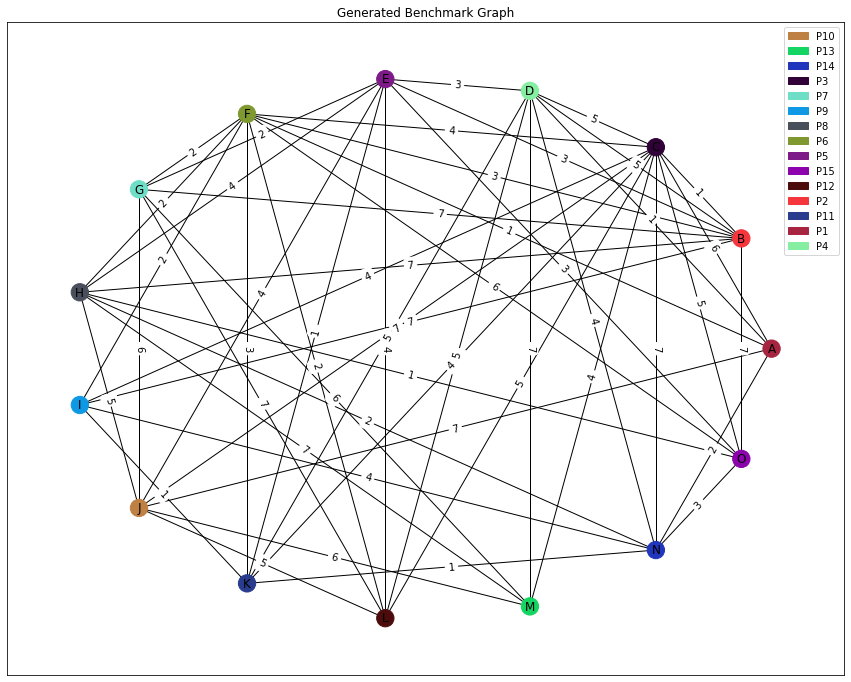

In [5]:
g = generate_benchmark(15, seed = 69)

graph = convert_to_our_graph(g)
v.addEdges(graph)
v.visualize("Generated Benchmark Graph")

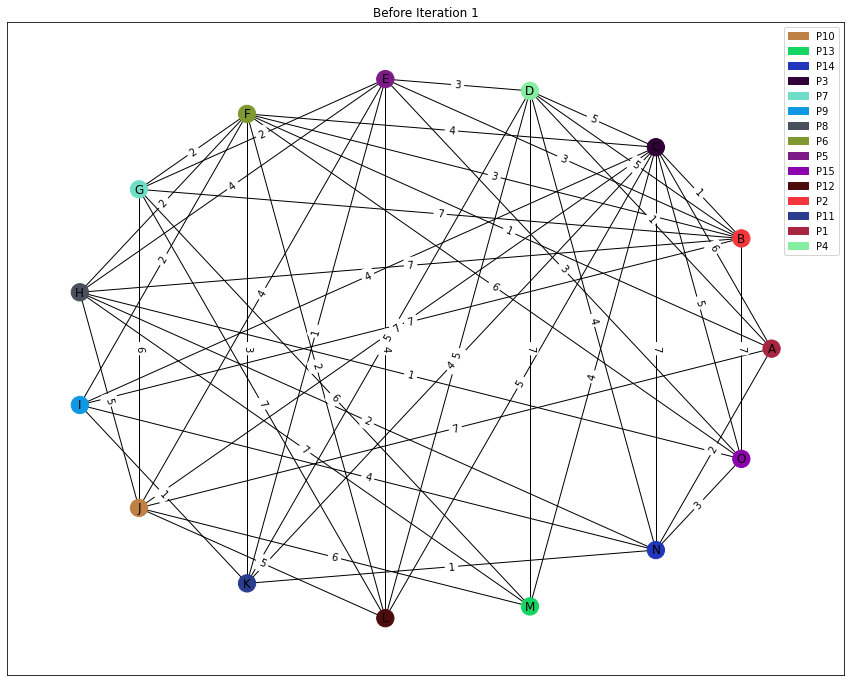

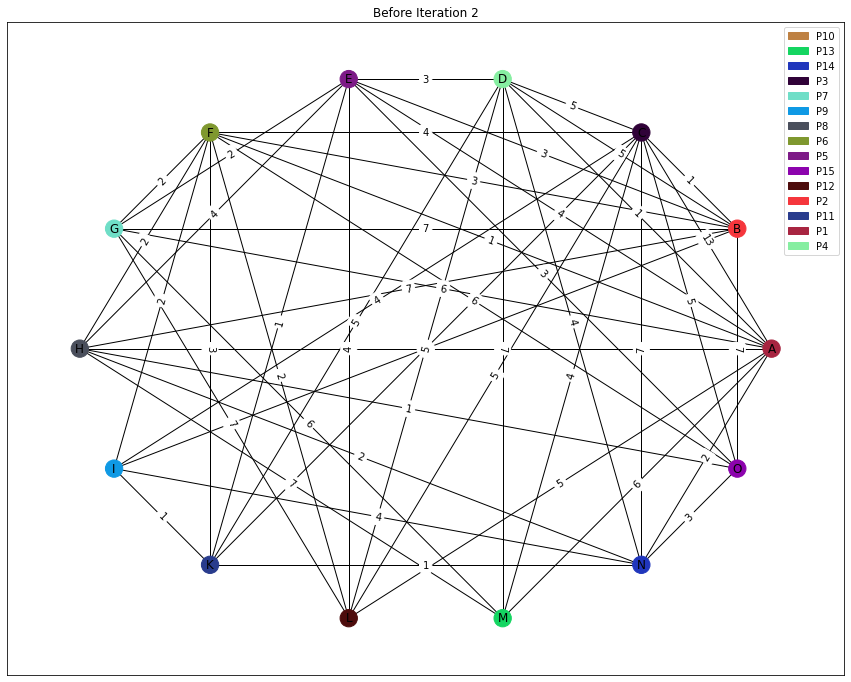

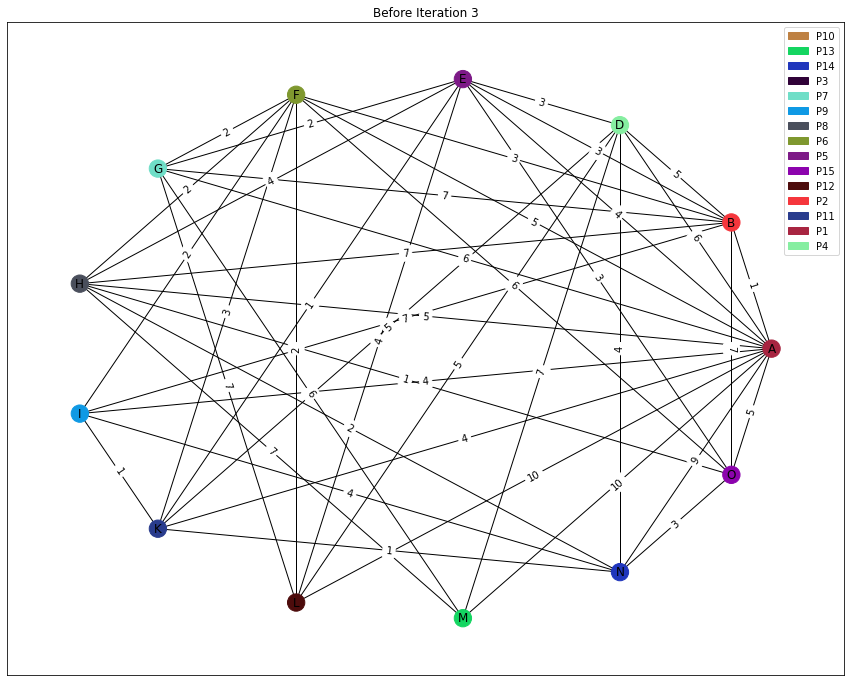

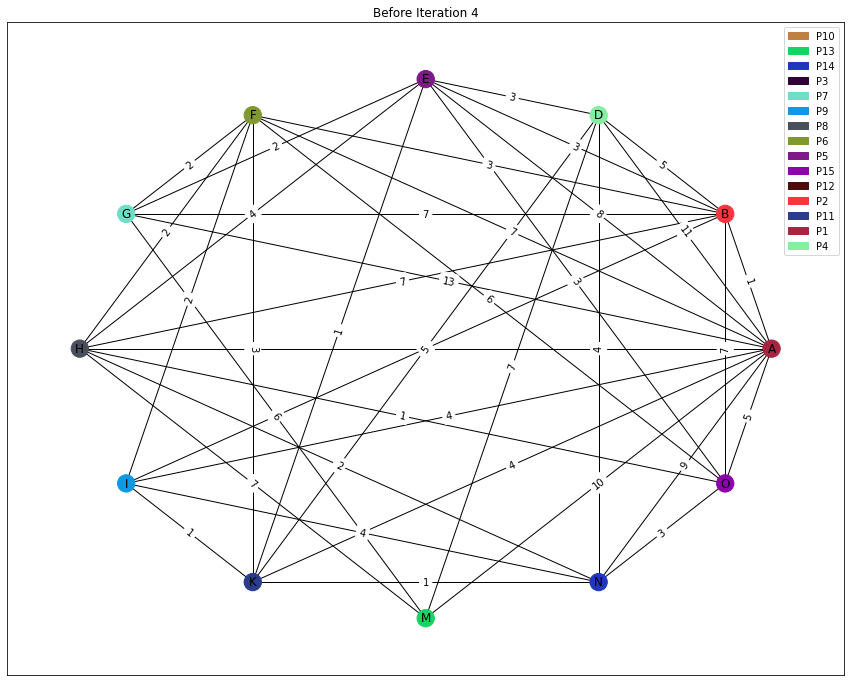

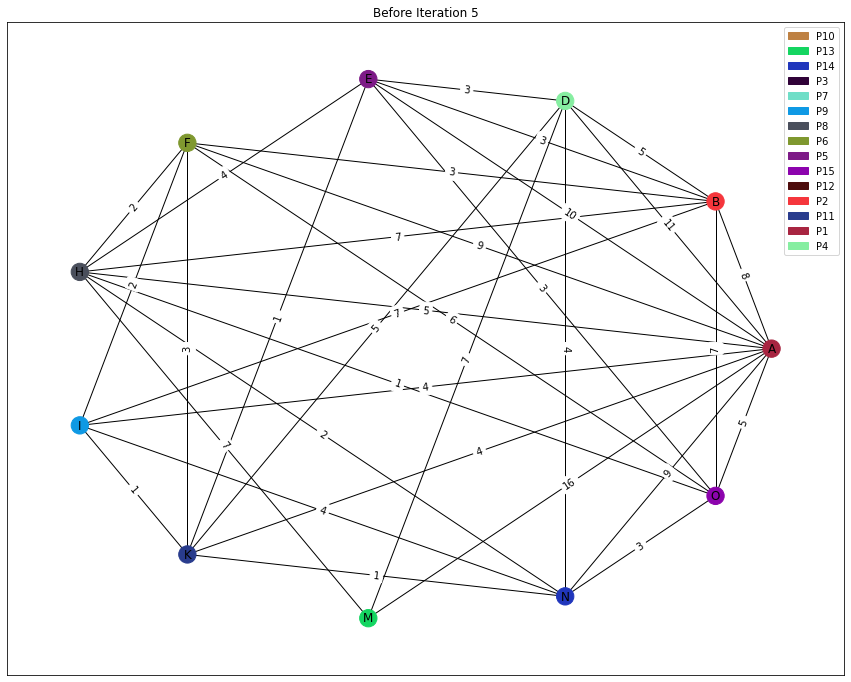

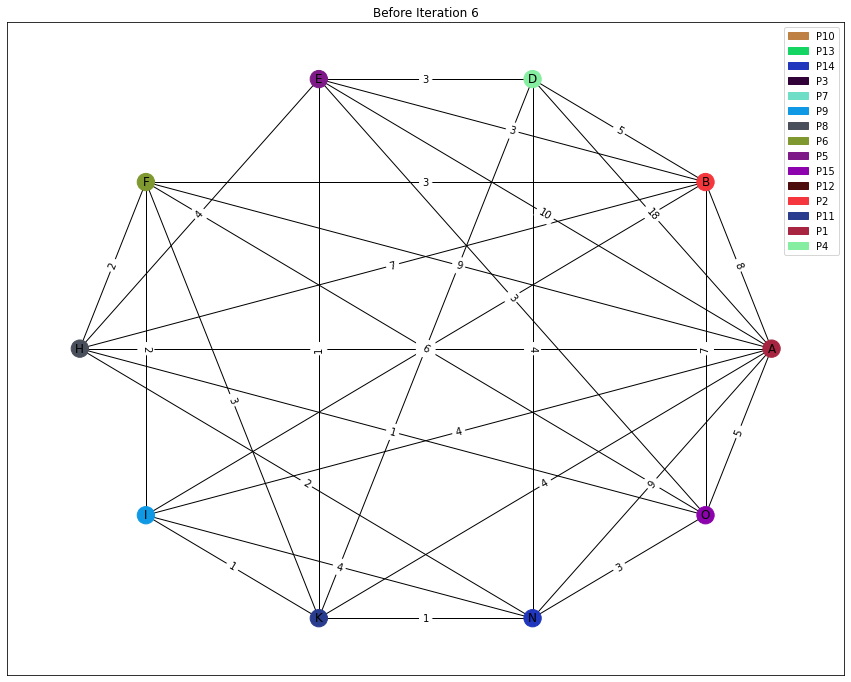

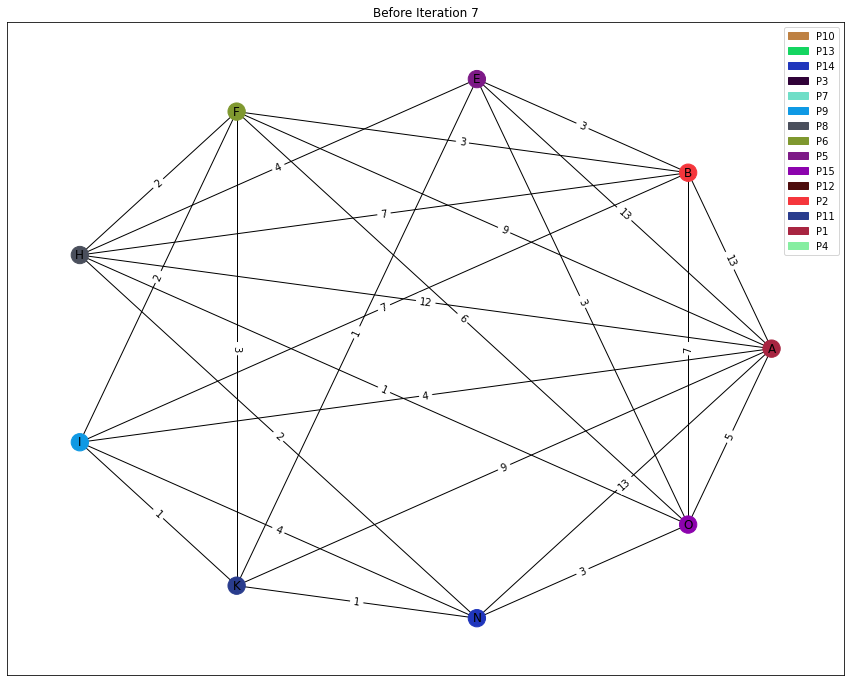

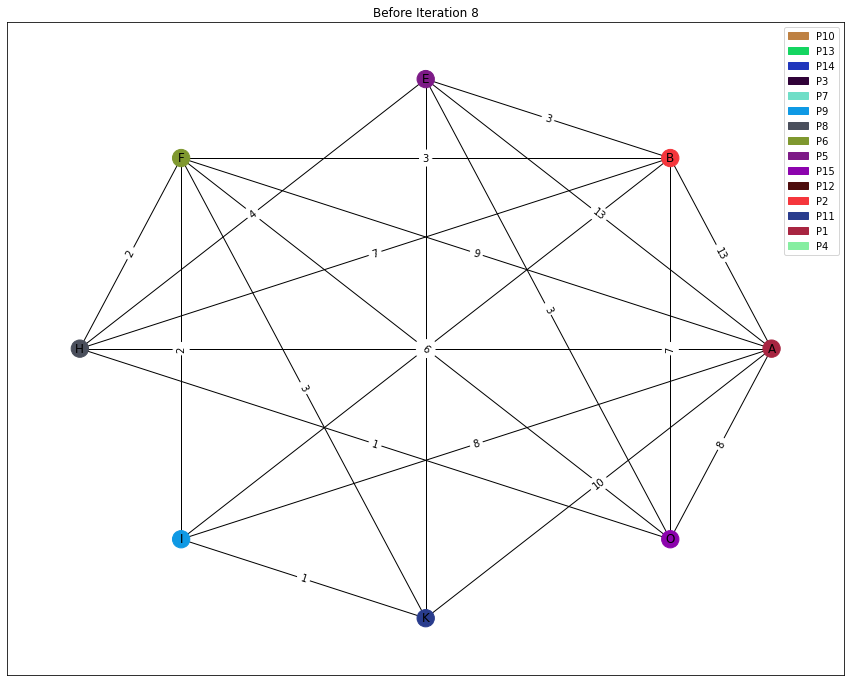

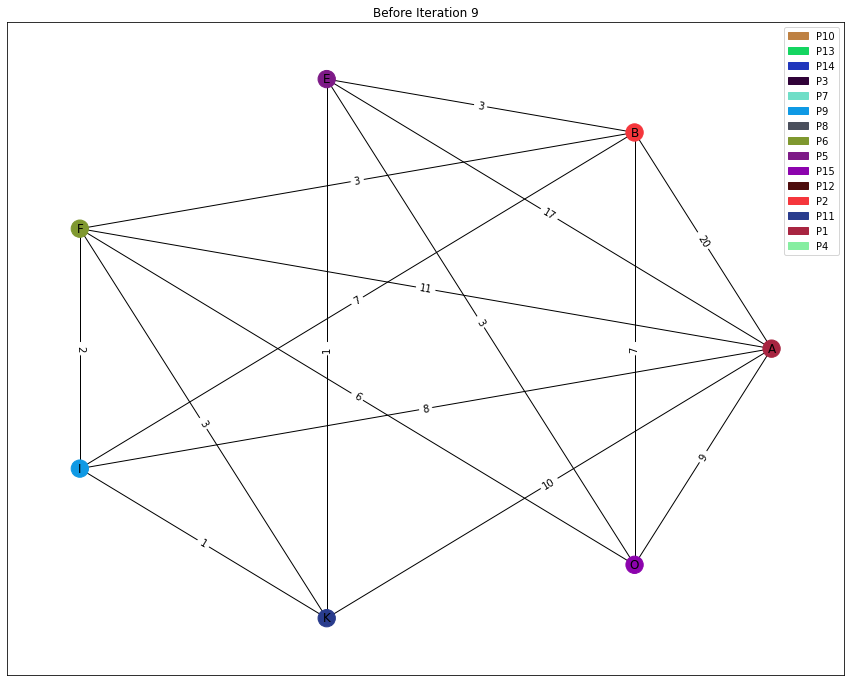

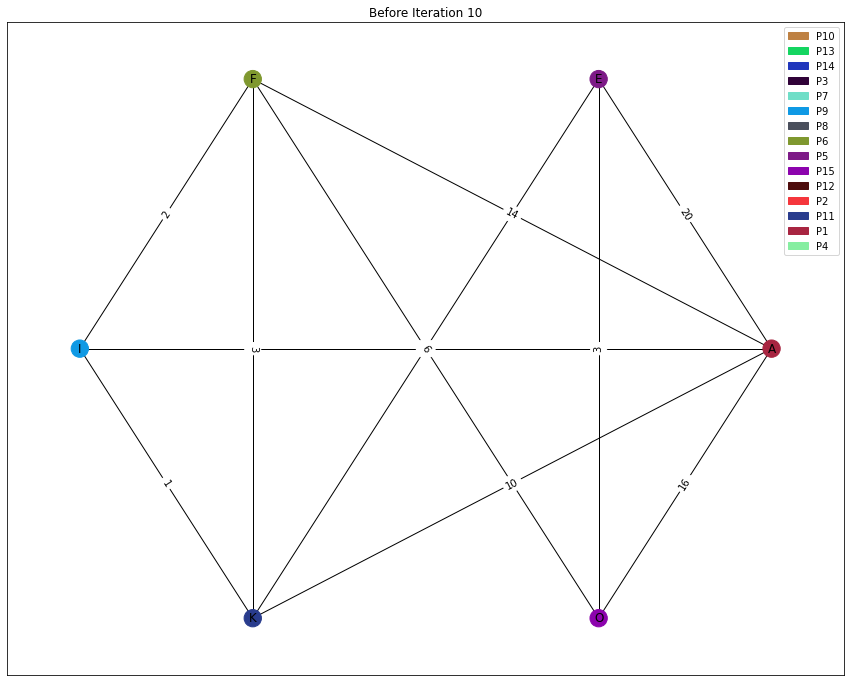

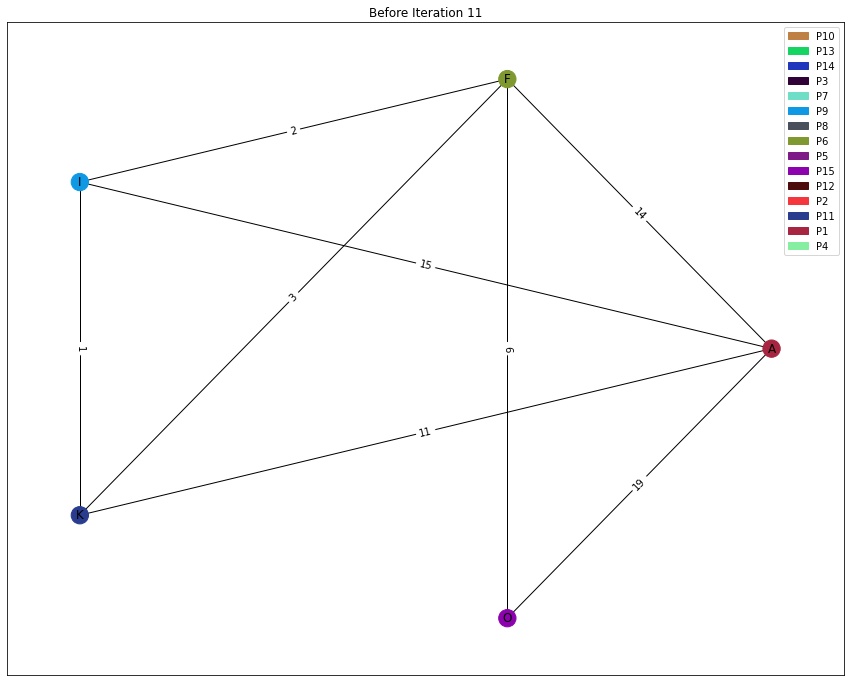

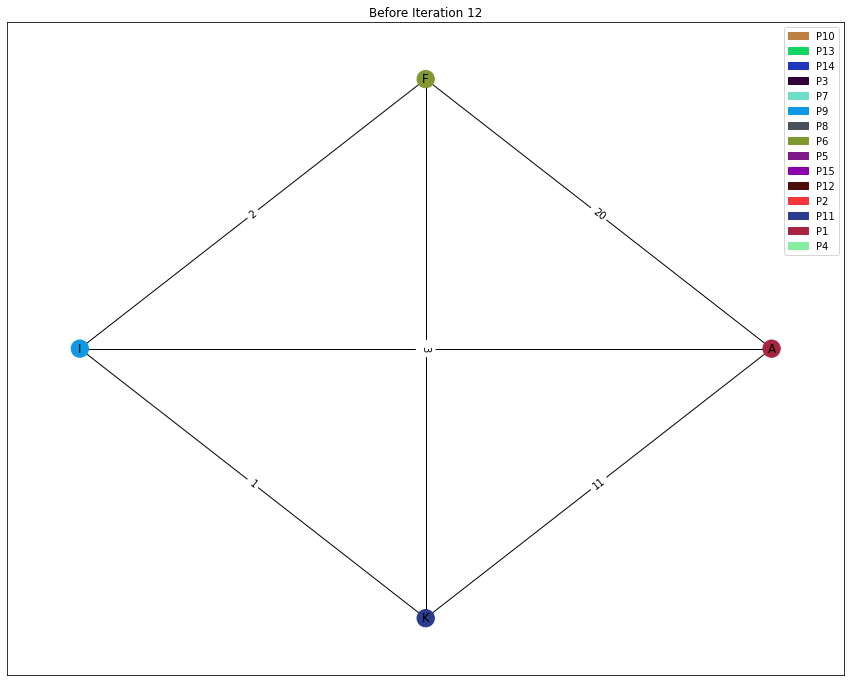

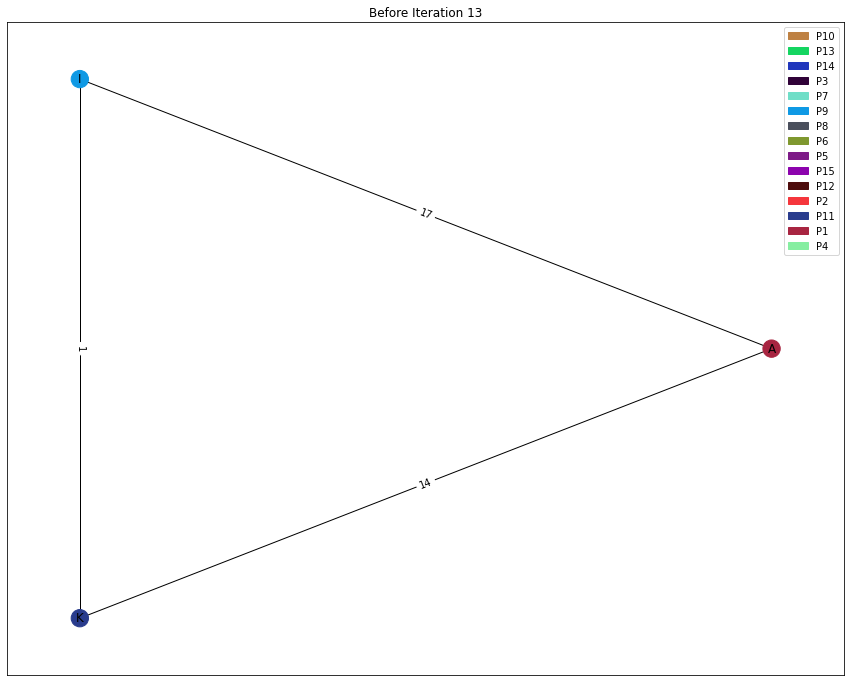

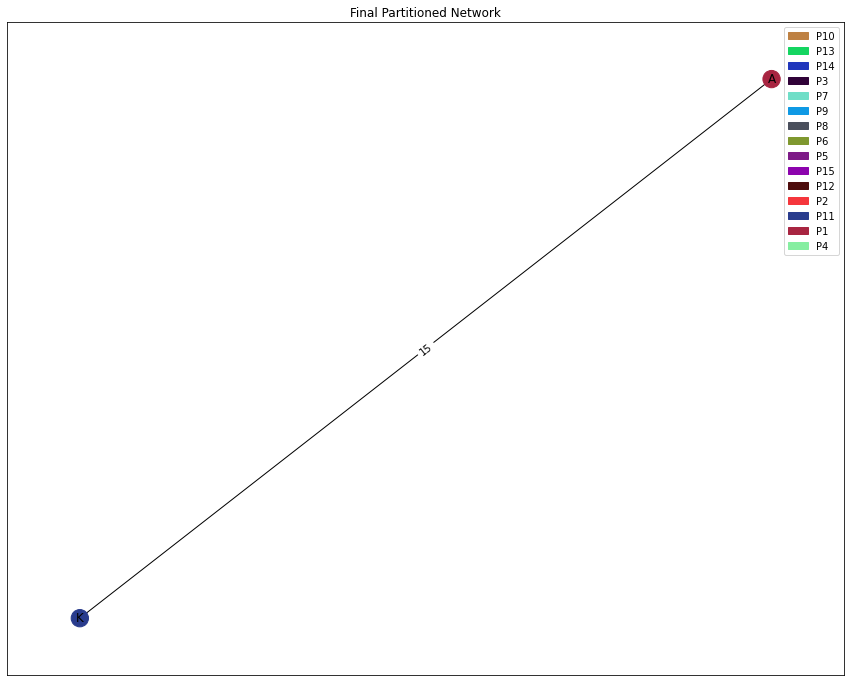

In [6]:
clustering_based_partitioning(graph, 2)

In [7]:
p1 = graph.node_part[graph.nodes[0]]
p2 = graph.node_part[graph.nodes[1]]

print("The first partition is given by", p1)
print("The first partition is given by", p2)

The first partition is given by ['A', 'J', 'C', 'L', 'G', 'M', 'D', 'N', 'H', 'B', 'E', 'O', 'F', 'I']
The first partition is given by ['K']


### Seeing Final Partition

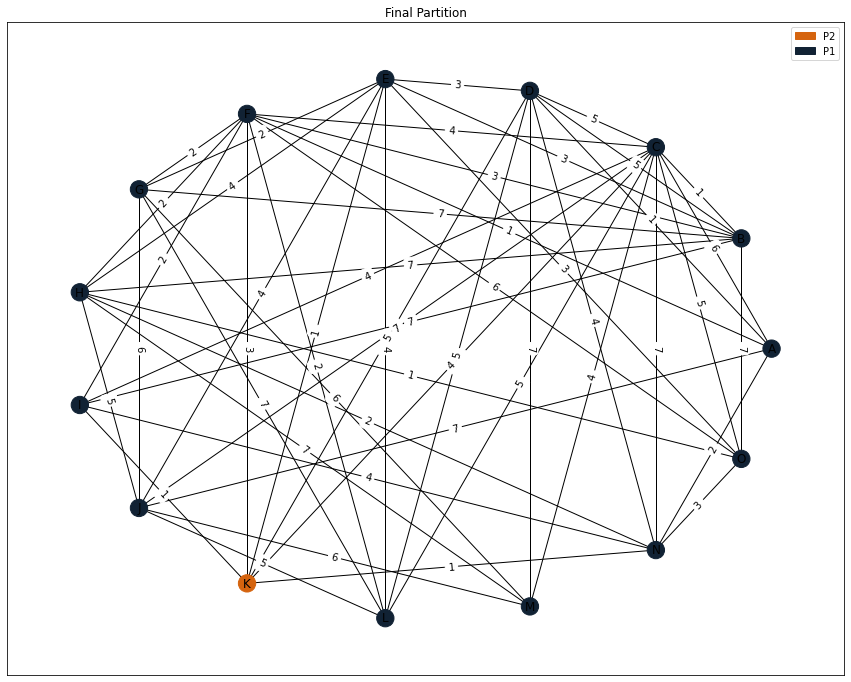

Final cost of partitioning 15


In [8]:
final = convert_to_our_graph(g)
for i in p1:
    final.node_affiliation[i] = 'P1'
for i in p2:
    final.node_affiliation[i] = 'P2'

v = GraphVisualizer()
v.addEdges(final)
v.visualize("Final Partition")
print("Final cost of partitioning", final.get_cost())

# Analysis of this method of Partitioning

To analyse this algorithm, we perform the following, we shall take 15 different networks of increasing sizes, which we shall use to compare the various algorithms, and tabulate for each example

Here are the results

In [9]:
import pandas as pd
import time

cutsizes = []
ratiocut = []

start_time = time.time()

for i in range(10, 26):
    g = generate_benchmark(i, seed = 440+i)
    graph = convert_to_our_graph(g) 
    clustering_based_partitioning(graph, 2, False)
    print(f"For the benchmark graph with {i} nodes, here is the tabulated results")
    
    p1 = graph.node_part[graph.nodes[0]]
    p2 = graph.node_part[graph.nodes[1]]

    final = convert_to_our_graph(g)
    
    for i in p1:
        final.node_affiliation[i] = 'P1'
    for i in p2:
        final.node_affiliation[i] = 'P2'
    
    result = pd.DataFrame({"P1":[p1], "P2":[p2], "length(P1)":[len(p1)], "length(P2)":[len(p2)], "Cutsize" : [final.get_cost()], "Ratio Cut" : [final.get_cost()/(len(p1)*len(p2))]})
    display(result)
    
    cutsizes.append(final.get_cost())
    ratiocut.append(final.get_cost()/(len(p1)*len(p2)))

print("Time of Execution --- %s seconds ---" % (time.time() - start_time))

For the benchmark graph with 10 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, E]","[B, C, G, F, I, D, H, J]",2,8,4,0.25


For the benchmark graph with 11 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, B, E, J, D, H, K, I, G, F]",[C],10,1,9,0.9


For the benchmark graph with 12 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, B, D, G, J, K, L, I, E, H, F]",[C],11,1,10,0.909091


For the benchmark graph with 13 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, B, H, K, J, D, C, E, I, G, L, M]",[F],12,1,16,1.333333


For the benchmark graph with 14 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, D, G, M, L, K, B, H, I, F, E, J, N]",[C],13,1,14,1.076923


For the benchmark graph with 15 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, D, G, I, K, L, M, J, E, N, O, F, B, C]",[H],14,1,11,0.785714


For the benchmark graph with 16 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, P, O, G, L, N, H, M, K, J, I, C, D, B, F]",[E],15,1,16,1.066667


For the benchmark graph with 17 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, E, L, M, H, C, K, G, J, P, D, F, I, O, N, B]",[Q],16,1,14,0.875


For the benchmark graph with 18 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, B, P, E, I, R, G, C, L, M, D, K, Q, F, H, ...",[N],17,1,20,1.176471


For the benchmark graph with 19 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, G, R, Q, H, E, B, D, F, O, K, J, S, L, C, ...",[P],18,1,20,1.111111


For the benchmark graph with 20 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, G, B, R, D, J, M, C, F, O, P, T, N, E, S, ...",[I],19,1,22,1.157895


For the benchmark graph with 21 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, K, I, P, T, U, O, M, Q, J, L, R, B, E, C, ...",[G],20,1,24,1.2


For the benchmark graph with 22 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, H, C, E, T, O, N, S, K, R, P, B, Q, V, D, ...",[F],21,1,30,1.428571


For the benchmark graph with 23 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, C, L, T, M, U, D, S, E, Q, W, B, R, V, I, ...",[F],22,1,18,0.818182


For the benchmark graph with 24 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, G, U, W, C, L, E, X, N, K, O, I, H, P, J, ...",[R],23,1,26,1.130435


For the benchmark graph with 25 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,"[A, F, J, N, B, S, K, P, E, C, X, V, U, I, Y, ...",[L],24,1,38,1.583333


Time of Execution --- 0.20137739181518555 seconds ---


#### We also see that this particular heuristic always gives a distribution with **highly unbalanced partitioning** mostly of (1, n-1) nodes, one example has (2, n-2) also.

## To find average cut size and average ratio cut

In [10]:
print("Average Cutsize", np.average(cutsizes))
print("Average Ratiocut", np.average(ratiocut))

Average Cutsize 18.25
Average Ratiocut 1.0501703794132538
